# Image Search Analysis for Transients

This notebook is meant to walk through the process of mosaicing images to detect transient sources in TTE data. This can be data originating from a GUANO data dump or subthreshold TTE data from some unknown rate increase that didn't actually trigger BAT. In this example notebook, we will be looking at TTE data from a GUANO data dump correspondent to GRB 210626A (see [GCN Circular 30325](https://gcn.nasa.gov/circulars/30325?query=210626A+&startDate=&endDate=)) which was localized using an image search analysis which occured over a time period where Swift was slewing.

In this notebook, we will shed light on how this analysis was done and extend the analysis to explore the lightcurve and spectral properties of this GRB. 

As usual, we will start off by importing the necessary packages. To search for GUANO data, we will use the [swiftools](https://www.swift.psu.edu/too_api/index.php?md=API_Format.md) python package which we import here.

In [1]:
import batanalysis as ba
from swifttools.swift_too import GUANO 

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from pathlib import Path
from astropy.io import fits
from astropy.time import Time, TimeDelta
import astropy.units as u
from astropy.coordinates import SkyCoord
import datetime
import os

%matplotlib widget


Now, lets search for the GUANO data that was downlinked for the trigger time of this GRB, 2021-06-26 08:16:15.9
UTC (as noted in the linked GCN above). We will use a begin and end time of the start and end of the day of interest here. The `limit=100` then denotes that we only want to collect the first 100 entries that are found (though there are significantly less that are found). 

In [2]:
guano = GUANO(begin="2021-06-26", end="2021-06-27", limit=100)
print(guano)

+--------------+----------------------------+------------+---------------------+----------------+
| Trigger Type |               Trigger Time | Offset (s) | Window Duration (s) | Observation ID |
+--------------+----------------------------+------------+---------------------+----------------+
|      GBM GRB | 2021-06-26 23:46:24.000001 |         50 |                 200 |    00014135005 |
|      GBM GRB |        2021-06-26 08:16:15 |         50 |                 200 |    00036799012 |
|      GBM GRB |        2021-06-26 00:00:00 |         50 |                 200 |    00035785004 |
+--------------+----------------------------+------------+---------------------+----------------+


We choose the second entry in the table because it has the exact trigger time that we care about. 

In [3]:
trigger=guano.entries[1]

Now, we can follow our usual methods of setting up our data directory and download the observation ID of interest.

In [4]:
tmp_download_dir="/tmp/batdata/download_examples"

ba.datadir(tmp_download_dir, mkdir=True)

download = ba.download_swiftdata(guano[1].obsid, quiet=False)

datadir=ba.datadir().joinpath(guano[1].obsid)

print(download)
print(ba.datadir())

{'00036799012': {'obsid': '00036799012', 'success': True, 'obsoutdir': PosixPath('/private/tmp/batdata/download_examples/00036799012'), 'quicklook': False, 'data': Swift_Data(username='anonymous',obsid='00036799012',quicklook='False',auxil='True',bat='True',xrt='False',uvot='False',log='False',tdrss='True')}}
/private/tmp/batdata/download_examples


/Users/tparsota/miniforge3/lib/python3.12/site-packages/swifttools/swift_too/swift_data.py:394: UserWarning: SWIFT_TLE_ARCHIVE.txt.21182.87130952.gz exists and not overwritten (set clobber=True to override this).
/Users/tparsota/miniforge3/lib/python3.12/site-packages/swifttools/swift_too/swift_data.py:394: UserWarning: sw00036799012pat.fits.gz exists and not overwritten (set clobber=True to override this).
/Users/tparsota/miniforge3/lib/python3.12/site-packages/swifttools/swift_too/swift_data.py:394: UserWarning: sw00036799012pjb.par.gz exists and not overwritten (set clobber=True to override this).
/Users/tparsota/miniforge3/lib/python3.12/site-packages/swifttools/swift_too/swift_data.py:394: UserWarning: sw00036799012pob.cat.gz exists and not overwritten (set clobber=True to override this).
/Users/tparsota/miniforge3/lib/python3.12/site-packages/swifttools/swift_too/swift_data.py:394: UserWarning: sw00036799012ppr.par.gz exists and not overwritten (set clobber=True to override this)

We can now load the dataset into the BATAnalysis's BatEvent class to ensure that various calibrations are considered. Since this is a GUANO dataset, we need to set `is_guano=True`. 

We will also see a warning pop up that the event data is mask weighted with some default coordinates which may not be the location of whatever source we may want to attempt to detect through imaging and analyze. Once we do our imaging to try to find the location of the GRB, we can redo the mask-weighting with the new coordinates. 

In [5]:
event=ba.BatEvent(guano[1].obsid, is_guano=True)
print(event.result_dir)

/private/tmp/batdata/download_examples/00036799012_eventresult


Lets take a look at the attitude of Swift at the time of the GRB trigger. We will see that the trigger time, shown as the red dashed line, occurs while the RA and Dec are changing. 

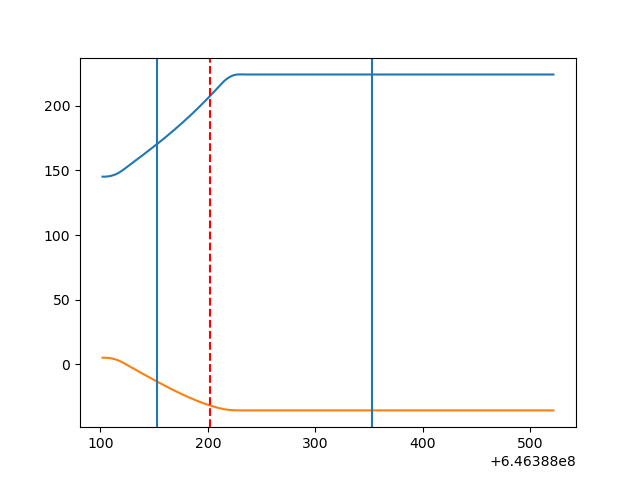

In [6]:
plt.figure()
plt.plot(event.attitude.time, event.attitude.ra)
plt.plot(event.attitude.time, event.attitude.dec)
plt.axvline(trigger.triggertime.met, color='r', ls='--')
plt.axvline(event.data.time.min().value)
plt.axvline(event.data.time.max().value)

Lets better define when Swift is slewing and when it is settled. To do so, we will look at different attitude flags related to the near field instruments being within 10 arcmin away from their intented target and the spacecraft actually being settled on the target of interest.

In [7]:
slew_idx=np.where((event.attitude.time>event.data.time.min()) & (event.attitude.time<event.data.time.max()) & (~ event.attitude.is_10arcmin_settled) & (~ event.attitude.is_settled))
settled_idx=np.where((event.attitude.time>event.data.time.min()) & (event.attitude.time<event.data.time.max()) & (event.attitude.is_10arcmin_settled) & (event.attitude.is_settled))

Plotting all the information together helps us understand the activities of Swift at the time of the GRB.

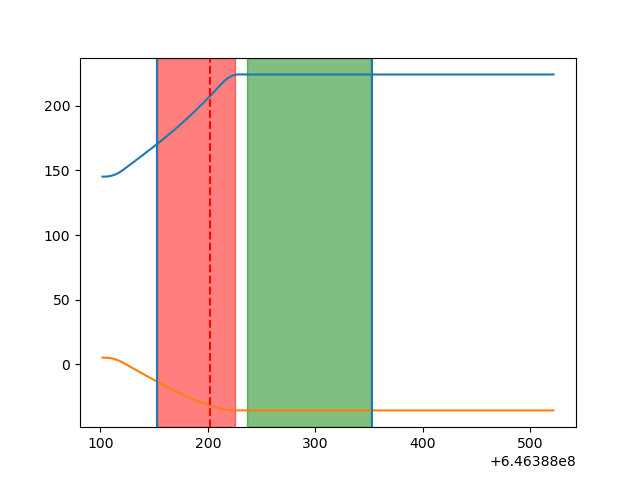

In [8]:
plt.figure()
plt.plot(event.attitude.time, event.attitude.ra)
plt.plot(event.attitude.time, event.attitude.dec)
plt.axvline(event.data.time.min().value)
plt.axvline(event.data.time.max().value)
plt.axvline(trigger.triggertime.met, color='r', ls='--')

plt.axvspan(event.attitude.time[slew_idx].min().value, event.attitude.time[slew_idx].max().value, color='red', alpha=0.5)
plt.axvspan(event.attitude.time[settled_idx].min().value, event.attitude.time[settled_idx].max().value, color='green', alpha=0.5)

## Settled Image Construction

Before we get to creating a mosaic image surrounding the trigger time, lets construct an image for the green shaded region, where Swift is settled. We will get a sense for how we can create images and some of the statistics of the images.

We will construct 4 images spanning the settled time interval for 4 energy bins. These images including background standard deviation images, exposure images, and the partial coding image are stored together in the BatSkyView object. This object holds a comprehensive view of the sky within BAT's field of view. 

In [9]:
#create a single skyview for the time period where we are settled
energybins=[ 15.,  25.,  50., 100., 350]*u.keV
timebin=u.Quantity([event.attitude.time[settled_idx].min(), event.attitude.time[settled_idx].max()])
settled_skyview = event.create_skyview(timebins=timebin, energybins=energybins)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 59391.346620 from DATE-END'. [astropy.wcs.wcs]


Now, lets plot what the SNR map looks like for the third energy range (50-100 keV) in the SKYX/Y coordinates. 

{'TIME_START': <Quantity [6.46388236e+08] s>, 'TIME_STOP': <Quantity [6.46388351e+08] s>, 'TIME_CENT': <Quantity [6.46388294e+08] s>} 115.0 s {'INDEX': array([1, 2, 3, 4]), 'E_MIN': <Quantity [ 15.,  25.,  50., 100.] keV>, 'E_MAX': <Quantity [ 25.,  50., 100., 350.] keV>}


(<Axes: xlabel='SKYX', ylabel='SKYY'>,
 <matplotlib.collections.QuadMesh at 0x15f3606b0>)

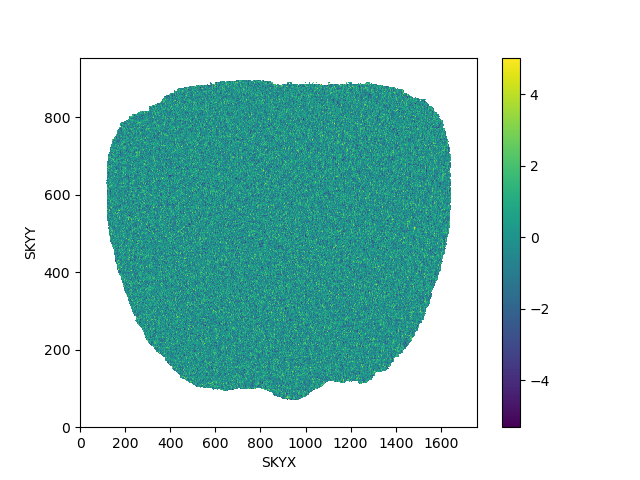

In [10]:
print(settled_skyview.sky_img.tbins,settled_skyview.sky_img.exposure, settled_skyview.sky_img.ebins)
e_resolved_snr=settled_skyview.snr_img.slice[dict(ENERGY=3)].project("SKYX","SKYY")
e_resolved_snr.plot()

It is difficult to tell what the distribution of the SNR pixels are so lets plot them explicitly alongside a gaussian with $\sigma=1$. We can see that the SNR distribution for the 50-100 keV energy range is well described by our gaussian. Furthermore, there are no pixels that have an SNR>7, which is the normal criteria for the BAT team to determine if a triggered event is real or not. This exemplifies why SNR=7 was chosen as the threshold.

Further in the notebook, we will explore the other energy ranges and the time integration effects that can come into play in the BAT images, which has ramifications for understanding the statistics of TTE images being mosaiced and relatedly the survey data mosaicing thresholds. 

(0.8, np.float64(91314.0))

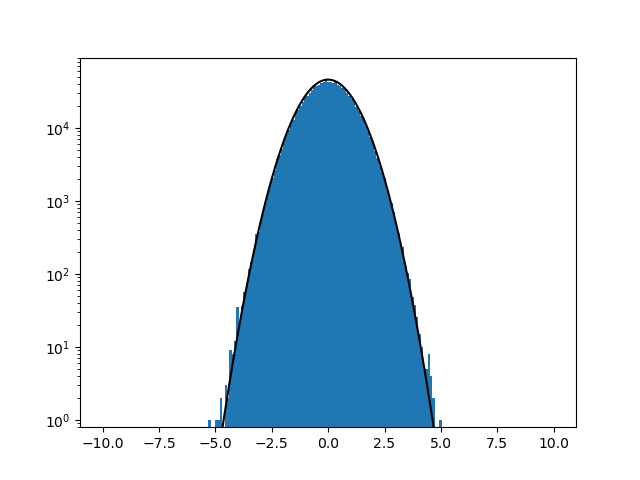

In [11]:
from astropy.modeling.models import Gaussian1D
plt.figure()
val, bins,_=plt.hist(e_resolved_snr.contents.flatten(), bins=100)

g = Gaussian1D(amplitude=val.max(), stddev=1)
x = np.arange(-10, 10, .01)
plt.plot(x, g(x), 'k-')
plt.yscale("log")
plt.ylim([0.8,2*val.max()])

Lets see what sources are detected in the settled images that we've produced in the different energy bands. 

We will see that there seem to be lots of sources detected above a CENT_SNR>6, which is the default value for a source to be listed in the table output of our call to `.detect_sources()` below. Looking at the CENT_SNR column for these sources, we can see that some seem to be detected at a CENT_SNR of $\sim 16$, which is in conflict with what we plotted just above. The underlying source detection algorithm actually measures the SNR of a source in each energy band that an image was created for. Thus, alot of these strong detections actually occur in the lowest energy band (15-25 keV). 

In [12]:
settled_skyview.detect_sources()

CATNUM,NAME,SKYCOORD,ALWAYS_CLEAN,TIME,TIME_STOP,EXPOSURE,IMX,IMY,IMX_ERR,IMY_ERR,IMXPIX,IMYPIX,RA_OBJ_ERR,DEC_OBJ_ERR,ERR_RAD,IMX_FWHM,IMY_FWHM,IMX_FHWM_ERR,IMY_FHWM_ERR,THETA,PHI,GRMCLON,GRMCLAT,COUNTS,COUNTS_ERR,CENT_COUNTS,CONTAM_COUNTS,BKG,BKG_ERR,BKG_VAR,BKG_CELL,BKG_FIT,SNR,CENT_SNR,NPIXSOU,NPIXBKG,DETECT_METHOD,CHI2,DOF,CHI2_NU,DETECT_STATUS,CONSTRAINT_FLAG,SRC_WINDOW_RAD,BKG_WINDOW_RAD,NGOODPIX,BAT_ZOBJ,PCODEFR,RA_PER_IMX,DEC_PER_IMX,RA_PER_IMY,DEC_PER_IMY,GAINAPP,CLOCKAPP,BTOFFAPP,FFAPP,NFAPP,PCODEAPP,NGPIXAPP,MSKWTAPP,BDISTAPP,BACKAPP,ACOLAPP
,,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int16,str30,SkyCoord,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[4],float64[4],float64[4],float64[4],float64[4],float64[4],float64[4],float64[4],float64[4],float64[4],float64[4],int32,int32,int32,float64[4],float64[4],float64[4],int32,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32
3,Sco X-1,"244.97950012913594,-15.640201682360678",True,646388236.4006,646388351.4006,115.0,0.2394609875418649,-0.4558485896389482,0.0,0.0,765.6325923354655,259.67355971315567,0.0,0.0,0.0,0.006529800274994075,0.006529800274994075,0.0,0.0,27.244707951764788,62.28668731699179,24.505803579712925,12.292063674724444,2.738185567710774 .. -0.07112694851108478,0.1784613616947662 .. 0.11114866433929672,2.550324800497781 .. -0.07522765556236868,0.042448637002218764 .. 0.027864374312368677,0.042448637002218764 .. 0.027864374312368677,0.0588786543162455 .. 0.03691024308576989,0.1583869904279709 .. 0.09830424934625626,0.033192701637744904 .. 0.033192701637744904,0.042448637002218764 .. 0.027864374312368677,17.287944927244574 .. -0.7235389007504133,16.10185782056124 .. -0.7652533442109397,0,0,2,121.23426697739703 .. 96.92066068102251,111.0 .. 111.0,1.0922006033999732 .. 0.8731591052344371,0,11,6,30,15648,10000000.0,0.48828125,-22.718180332503835,44.70569692394122,-45.28704590711641,-16.33299614134387,1,0,1,1,0,1,1,1,0,0,1
761,1RXS J165605.6-520345,"254.0234002231917,-52.06140046288597",False,646388236.4006,646388351.4006,115.0,-0.44173540345407103,-0.2404867588603348,0.0,0.0,1089.902428495126,362.19677859669207,0.0,0.0,0.0,0.006529800274994075,0.006529800274994075,0.0,0.0,26.700352596158158,151.43552664451119,13.522100665511223,-23.24305907013698,-0.32880943636434 .. -0.12059385698999087,0.15172359242685718 .. 0.09446542842167628,-0.33297241020508517 .. -0.17000111467117546,0.11715209770508514 .. 0.09334095842117544,0.11715209770508514 .. 0.09334095842117544,0.051050150376405895 .. 0.031494554909016474,0.13294045627117157 .. 0.08342146873474121,0.0134623683989048 .. 0.0134623683989048,0.11715209770508514 .. 0.09334095842117544,-2.473358717030694 .. -1.445597384211111,-2.504673291671942 .. -2.0378580867682303,0,0,2,83.08963443094099 .. 89.33687134221,111.0 .. 111.0,0.7485552651436125 .. 0.8048366787586487,0,11,6,30,15648,10000000.0,0.6875,-41.09030641075151,39.670888050125086,-64.15116376956576,-30.716211881554045,1,0,1,1,0,1,1,1,0,0,1
5130,SNR G311.5-00.3,"211.40000004847337,-61.97000041603879",False,646388236.4006,646388351.4006,115.0,-0.4632865609567772,0.2390632298797311,0.0,0.0,1100.15679312527,590.422622612431,0.0,0.0,0.0,0.006529800274994075,0.006529800274994075,0.0,0.0,27.53441283785326,-152.7055466938766,-13.444972716822614,-24.255830903217156,0.16297096360748692 .. 0.2662738960779464,0.12779311571160168 .. 0.0937686313908699,0.15063640599965983 .. 0.24964960204433295,-0.07446453099965981 .. -0.04457147704433296,-0.07446453099965981 .. -0.04457147704433296,0.043015430679041095 .. 0.031407574794067875,0.11162871867418289 .. 0.08227541297674179,-0.05374941974878311 .. -0.05374941974878311,-0.07446453099965981 .. -0.04457147704433296,1.4599375997780604 .. 3.236372646992591,1.3494413246767698 .. 3.0343160005153145,0,0,2,150.

Now, lets take a look at how the SNR distributions can change for the different energy ranges. We highlight the different energy ranges, gaussians with $\sigma=1$, and the SNR=7 threshold that is typically considered a real source by the BAT Team (for an unknown transient). 

As mentioned, there are lots of sources that are strongly detected in the 15-25 keV energy range, such as Sco X-1 so we expect the SNR histogram for this energy range to have many very significant pixels with SNR>7. 

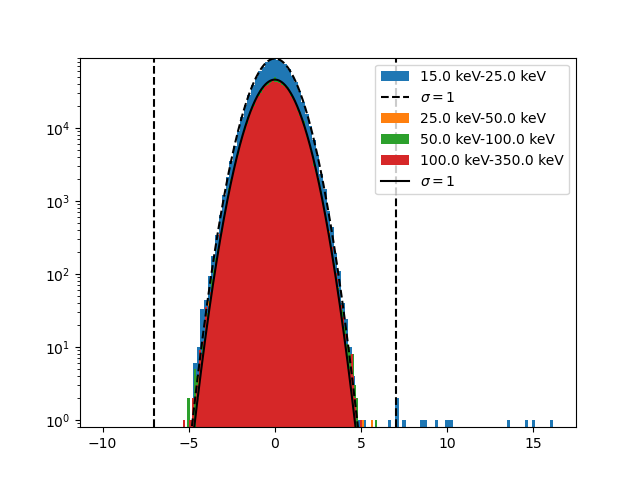

In [13]:
plt.figure()
energy_ax=settled_skyview.snr_img.axes["ENERGY"]
for emin, emax, i in zip(energy_ax.lower_bounds, energy_ax.upper_bounds, range(energy_ax.nbins)):
    e_resolved_snr=settled_skyview.snr_img.slice[dict(ENERGY=i)].project("SKYX","SKYY")
    val, bins,_=plt.hist(e_resolved_snr.contents.flatten(), bins=100, label=f"{emin}-{emax}")
    
    if i==0:
        g = Gaussian1D(amplitude=val.max(), stddev=1)
        x = np.arange(-10, 10, .01)
        plt.plot(x, g(x), 'k--', label=r"$\sigma=1$")
        plt.yscale("log")
        plt.ylim([0.8,2*val.max()])
        
g = Gaussian1D(amplitude=val.max(), stddev=1)
x = np.arange(-10, 10, .01)
plt.plot(x, g(x), 'k-', label=r"$\sigma=1$")
plt.yscale("log")
plt.ylim([0.8,2*val.max()])


plt.axvline(-7, color='k', ls='--')
plt.axvline(7, color='k', ls='--')

plt.legend()
    

Next, lets look at how the exposure time of an image in a single 15-350 keV energybin changes the statistics. 

We can see that as the image integration time increases, the SNR histograms diverge from a gaussian. As integration time increases there can be an increased number of pixels with SNR values that diverge from a gaussian. It is important to note that these pixels can be noise but can also be sources that are real, such as Sco X-1. Once again, the BAT Team considers real sources to be those that have SNR>7 so only one pixel in the final 115 second integration image would be considered real (which is the pixel associated with Sco X-1).

Text(0.5, 1.0, '15-350 keV')

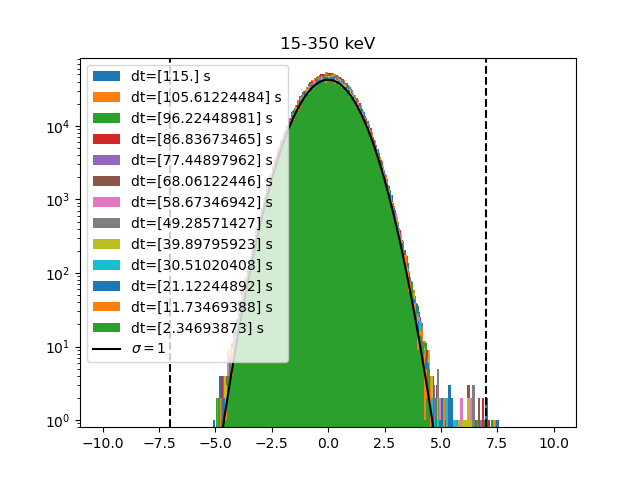

In [14]:
skyview_times=np.linspace(timebin[0], timebin[1])[1:]
ebin=[ 15., 350]*u.keV

plt.figure()

for i in skyview_times[::4][::-1]:
    tbin=u.Quantity([timebin[0], i])
    diff_exp_skyview = event.create_skyview(timebins=tbin, energybins=ebin)
    
    diff_exp_snr=diff_exp_skyview.snr_img.slice[dict(ENERGY=0)].project("SKYX","SKYY")
    val, bins,_=plt.hist(diff_exp_snr.contents.flatten(), bins=100, label=f"dt={np.diff(tbin)}")


g = Gaussian1D(amplitude=val.max(), stddev=1)
x = np.arange(-10, 10, .01)
plt.plot(x, g(x), 'k-', label=r"$\sigma=1$")
plt.yscale("log")
plt.ylim([0.8,2*val.max()])


plt.axvline(-7, color='k', ls='--')
plt.axvline(7, color='k', ls='--')

plt.legend()
plt.title("15-350 keV")


We can also expand our analysis of the integration time to consider different energy ranges: 15-25, 25-50, 50-100, and 100-350 keV. 

First, lets look at the SNR histograms in the 15-25 keV energy range for different integration times. This energy range is generally the noisiest since it is where the detectors are typically noisy and many sources are bright which can create artifacts in the resulting image if it isn't properly cleaned. The plotted SNR histograms below show that there are many pixels with SNR>7 regardless of the integration time due to the various effects that were just mentioned. 

Text(0.5, 1.0, '15-25 keV')

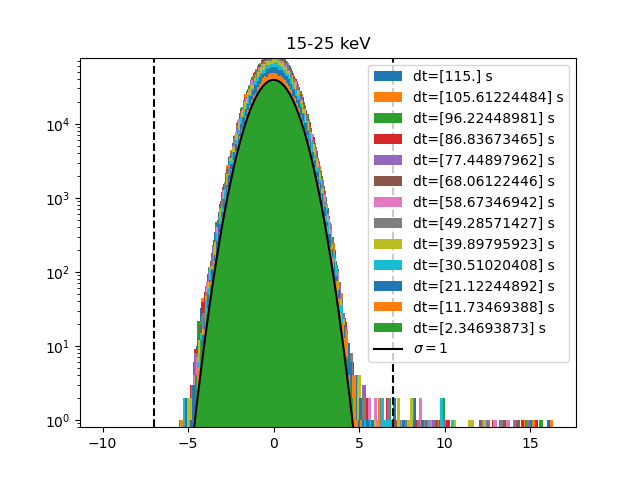

In [15]:
ebin=[ 15.,  25.,  50., 100., 350]*u.keV

plt.figure()

for i in skyview_times[::4][::-1]:
    tbin=u.Quantity([timebin[0], i])
    diff_exp_skyview = event.create_skyview(timebins=tbin, energybins=ebin)
    
    diff_exp_snr=diff_exp_skyview.snr_img.slice[dict(ENERGY=0)].project("SKYX","SKYY")
    val, bins,_=plt.hist(diff_exp_snr.contents.flatten(), bins=100, label=f"dt={np.diff(tbin)}")


g = Gaussian1D(amplitude=val.max(), stddev=1)
x = np.arange(-10, 10, .01)
plt.plot(x, g(x), 'k-', label=r"$\sigma=1$")
plt.yscale("log")
plt.ylim([0.8,2*val.max()])


plt.axvline(-7, color='k', ls='--')
plt.axvline(7, color='k', ls='--')

plt.legend()
plt.title("15-25 keV")

The remaining energy ranges are simple to discuss since they generally contain less noise due to detectors and the astrophysical backgrond. The SNR histograms for the 25-50, 50-100, and 100-350 keV ranges are shown below. They all follow gaussian distributions with $\sigma=1$ except for a few pixels with slightly larger SNR values. Nonetheless, no pixels have SNR>7 values. We expect this since the GRB that had a trigger time during the slew should have faded by the time Swift was settled and there are no bright astrophysical sources that are prevelant at these energy ranges in the BAT field of view. In the next section, we will construct our slew mosaic and detect/localize our GRB within the image that we create.

Text(0.5, 1.0, '25-50 keV')

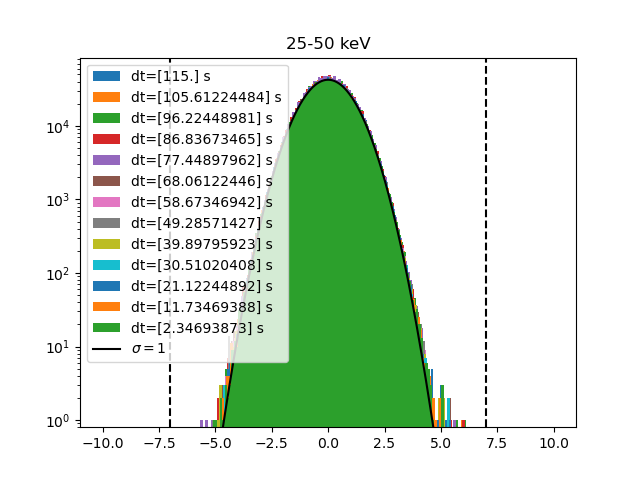

In [16]:
plt.figure()

for i in skyview_times[::4][::-1]:
    tbin=u.Quantity([timebin[0], i])
    diff_exp_skyview = event.create_skyview(timebins=tbin, energybins=ebin)
    
    diff_exp_snr=diff_exp_skyview.snr_img.slice[dict(ENERGY=1)].project("SKYX","SKYY")
    val, bins,_=plt.hist(diff_exp_snr.contents.flatten(), bins=100, label=f"dt={np.diff(tbin)}")

g = Gaussian1D(amplitude=val.max(), stddev=1)
x = np.arange(-10, 10, .01)
plt.plot(x, g(x), 'k-', label=r"$\sigma=1$")
plt.yscale("log")
plt.ylim([0.8,2*val.max()])


plt.axvline(-7, color='k', ls='--')
plt.axvline(7, color='k', ls='--')

plt.legend()
plt.title("25-50 keV")

Text(0.5, 1.0, '50-100 keV')

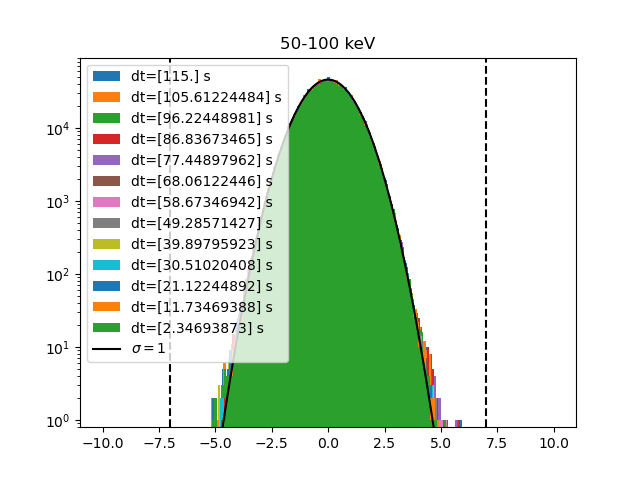

In [17]:
plt.figure()


for i in skyview_times[::4][::-1]:
    tbin=u.Quantity([timebin[0], i])
    diff_exp_skyview = event.create_skyview(timebins=tbin, energybins=ebin)
    
    diff_exp_snr=diff_exp_skyview.snr_img.slice[dict(ENERGY=2)].project("SKYX","SKYY")
    val, bins,_=plt.hist(diff_exp_snr.contents.flatten(), bins=100, label=f"dt={np.diff(tbin)}")


g = Gaussian1D(amplitude=val.max(), stddev=1)
x = np.arange(-10, 10, .01)
plt.plot(x, g(x), 'k-', label=r"$\sigma=1$")
plt.yscale("log")
plt.ylim([0.8,2*val.max()])


plt.axvline(-7, color='k', ls='--')
plt.axvline(7, color='k', ls='--')

plt.legend()
plt.title("50-100 keV")

Text(0.5, 1.0, '100-350 keV')

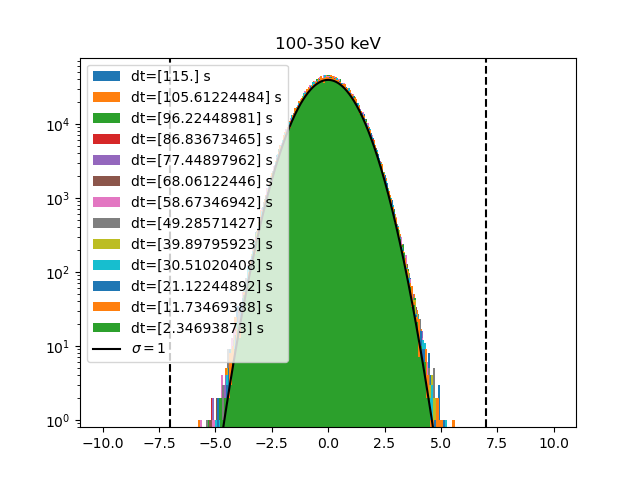

In [18]:
plt.figure()


for i in skyview_times[::4][::-1]:
    tbin=u.Quantity([timebin[0], i])
    diff_exp_skyview = event.create_skyview(timebins=tbin, energybins=ebin)
    
    diff_exp_snr=diff_exp_skyview.snr_img.slice[dict(ENERGY=3)].project("SKYX","SKYY")
    val, bins,_=plt.hist(diff_exp_snr.contents.flatten(), bins=100, label=f"dt={np.diff(tbin)}")


g = Gaussian1D(amplitude=val.max(), stddev=1)
x = np.arange(-10, 10, .01)
plt.plot(x, g(x), 'k-', label=r"$\sigma=1$")
plt.yscale("log")
plt.ylim([0.8,2*val.max()])


plt.axvline(-7, color='k', ls='--')
plt.axvline(7, color='k', ls='--')

plt.legend()
plt.title("100-350 keV")

## Mosaic Image Construction

Here, we will proceed with trying to detect the GRB during the slew period. In order to do this, we need to construct images while the spacecraft is approximately settled and then add up, or mosaic, these images to increase the signal of the GRB. Much of the discuss for these various points can be found here: [https://asd.gsfc.nasa.gov/archive/exist/papers/instrumentation/Copete_2009_BATSS.pdf](https://asd.gsfc.nasa.gov/archive/exist/papers/instrumentation/Copete_2009_BATSS.pdf)

We will create images from -5 to +10 seconds relative to the trigger time in 0.2 second intervals. We will also construct the images in 4 energy bands. There are a total of 75 x 4 = 300 images created for this analysis, exluding the background standard deviation images and the SNR images. Including those, we will be producing 300 x 3 = 900 images in total for this mosaic analysis. 

The chosen relative start and end times are the time when the GRB is brightest which allow us to maximize our SNR for this GRB. See [GCN Circular 30323](https://gcn.nasa.gov/circulars/30323?query=210626A+&startDate=&endDate=) for the link to the GRB's GBM lightcurve.

In [19]:
time_bins=np.arange(-5,10, 0.2)*u.s
energybins=[ 15.,  25.,  50., 100., 350]*u.keV
print(time_bins, len(time_bins))

[-5.0000000e+00 -4.8000000e+00 -4.6000000e+00 -4.4000000e+00
 -4.2000000e+00 -4.0000000e+00 -3.8000000e+00 -3.6000000e+00
 -3.4000000e+00 -3.2000000e+00 -3.0000000e+00 -2.8000000e+00
 -2.6000000e+00 -2.4000000e+00 -2.2000000e+00 -2.0000000e+00
 -1.8000000e+00 -1.6000000e+00 -1.4000000e+00 -1.2000000e+00
 -1.0000000e+00 -8.0000000e-01 -6.0000000e-01 -4.0000000e-01
 -2.0000000e-01  4.4408921e-15  2.0000000e-01  4.0000000e-01
  6.0000000e-01  8.0000000e-01  1.0000000e+00  1.2000000e+00
  1.4000000e+00  1.6000000e+00  1.8000000e+00  2.0000000e+00
  2.2000000e+00  2.4000000e+00  2.6000000e+00  2.8000000e+00
  3.0000000e+00  3.2000000e+00  3.4000000e+00  3.6000000e+00
  3.8000000e+00  4.0000000e+00  4.2000000e+00  4.4000000e+00
  4.6000000e+00  4.8000000e+00  5.0000000e+00  5.2000000e+00
  5.4000000e+00  5.6000000e+00  5.8000000e+00  6.0000000e+00
  6.2000000e+00  6.4000000e+00  6.6000000e+00  6.8000000e+00
  7.0000000e+00  7.2000000e+00  7.4000000e+00  7.6000000e+00
  7.8000000e+00  8.00000

With our timebins and energy bins specified, we can now create the images that we need. 
This can be done serially, as is shown in the commented potion of the cell below by calling the `.create_skyview` method of the event object that we created.

***or***

This can be done in parallel since each skyview doesnt need any information from the others. this is shown in the uncommented portion  of the cell where the `create_event_skyview` function is called with `nprocs=8`. This function has a memory saving parameter `parse_images`, which when set to `True` which is the default, will load all the differnet skyimages into the BAtSkyView object. If we only care about the end point mosaic BatSkyView and not the individual BatSkyViews we should set `parse_images=False`, as we do below. 

In [21]:
#%%time
#slew_skyviews=event.create_skyview(timebins=time_bins, energybins=energybins, is_relative=True, T0=trigger.triggertime.met)
# OR
%time
slew_skyviews=ba.parallel.create_event_skyview(event, timebins=time_bins, energybins=energybins, is_relative=True, \
                                               T0=trigger.triggertime.met, parse_images=False, nprocs=8)
#with nprocs=2, we had Wall time: 23min 46s
#with nprocs=4, we had Wall time: 17min 8s
#with nprocs=8, we had Wall time: 14min 3s

CPU times: user 3 μs, sys: 1e+03 ns, total: 4 μs
Wall time: 9.06 μs


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 59391.346620 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 59391.346620 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 59391.346620 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 59391.346620 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 59391.346620 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is d

We can now add our images together. Each image is projected onto a healpix map and then they are added together where each pixel is weighted by its inverse variance, identical to the mosiacing process for survey data. Pixels with partial coding fractions $< 15$% are excluded from the addition, which is also the partial coding threshold used in the survey data mosaicing process.

By default, the healpix map has `nside=512` and is in galactic coordinates. The skyviews can in theory be added in parallel, but this has not been implemented as of yet. Once this is implemented, users will be able to call the same code below with different values for `nprocs` besides 1. For now, we will stick with `nprocs=1` to allow the images to be mosaiced serially. 

The function below effectively runs:
```
for i in slew_skyviews:
    i.healpix_nside = 512
    i.projection = "healpix"
    i.healpix_coordsys = "galactic"

for i,count in zip(slew_skyviews, range(len(slew_skyviews))):
    if count==0:
        mosaic_skyview = i
    else:
        mosaic_skyview += i
```

In [22]:
%time
mosaic_skyview = ba.parallel.mosaic_skyview(slew_skyviews, nprocs=1)
#with nprocs=1 we have Wall time: 33min 22s

/Users/tparsota/miniforge3/lib/python3.12/site-packages/astropy/units/decorators.py:313: UserWarning: No astropy World Coordinate System has been specified the sky image is assumed to be in the detector tangent plane. No conversion to Healpix or RA/Dec & galactic coordinate systems will be possible.
/Users/tparsota/miniforge3/lib/python3.12/site-packages/histpy/histogram.py:1399: RuntimeWarning: invalid value encountered in divide


CPU times: user 28min 43s, sys: 3min, total: 31min 44s
Wall time: 32min 21s


Let us try to detect sources in our mosaiced skyview. This uses the same `.detect_sources` method that we used earlier. Since we are dealing with a helapix map as our underlying image format, the output of this method is slightly different. Instead of getting an output identical to what we get with HEASoft's `batcelldetect`, we instead apply a simple approximation of the `batcelldetect` algorithm  to the healpix maps. We identify healpix pixels (in each energy range) with SNR values greater than some threshold and find their closest known source in a catalog of known sources. We then identify how far away the known source is in degrees and in multiples of the BAT's point spead function full width half max. 

As we can see below there are many pixels in different energy ranges with SNR>6. These coordinates are also ~12 FWHMs away from the closest known source which means that they are likely very distinct new sources. As we will see, these are all associated with the newly detected GRB and are neighboring pixels.  

In [23]:
mosaic_detected_sources = mosaic_skyview.detect_sources()
mosaic_detected_sources

/Users/tparsota/miniforge3/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide


SNR_skycoord,SNR,closest_source,closest_source_skycoord,separation,psffwhm_separation,ebin
"deg,deg",,,"deg,deg",deg,,
SkyCoord,float64,str30,SkyCoord,float64,float64,float64[2]
"221.5187224762318,-1.1793388910250655",12.438784809989711,SDSS J142917.68+012058.7,"217.323699,1.349665",4.898079846711272,13.091919511162622,15.0 .. 25.0
"221.5187224762318,-1.1793388910250655",15.077973790571573,SDSS J142917.68+012058.7,"217.323699,1.349665",4.898079846711272,13.091919511162622,25.0 .. 50.0
"221.5187224762318,-1.1793388910250655",12.094945141798902,SDSS J142917.68+012058.7,"217.323699,1.349665",4.898079846711272,13.091919511162622,50.0 .. 100.0
"221.61879123841413,-1.0885917531620302",11.843048855868389,SDSS J142917.68+012058.7,"217.323699,1.349665",4.938626641556739,13.200295730245472,15.0 .. 25.0
"221.61879123841413,-1.0885917531620302",13.8138934191237,SDSS J142917.68+012058.7,"217.323699,1.349665",4.938626641556739,13.200295730245472,25.0 .. 50.0
"221.61879123841413,-1.0885917531620302",10.718426045483975,SDSS J142917.68+012058.7,"217.323699,1.349665",4.938626641556739,13.200295730245472,50.0 .. 100.0
"221.59296526673933,-1.243130404046864",10.635190734941597,SDSS J142917.68+012058.7,"217.323699,1.349665",4.99460668136951,13.349922971612836,15.0 .. 25.0
"221.59296526673933,-1.243130404046864",11.159754777300458,SDSS J142917.68+012058.7,"217.323699,1.349665",4.99460668136951,13.349922971612836,25.0 .. 50.0


Here, we show that the pixel that has the largest SNR is only 1.4 arcmin away from the known location of the GRB (see the aforementioned GCNs). The other pixels (some are the same pixel in different energy range images) are up to ~11 arcmin away and gives the localization error in the mosaic technique. 

In [24]:
mosaic_detected_coords=mosaic_detected_sources[0]["SNR_skycoord"]
orig_coords=SkyCoord(ra=221.52429*u.deg, dec=-1.15625*u.deg)
print(mosaic_detected_coords.separation(orig_coords).to(u.arcmin))
print(mosaic_detected_sources["SNR_skycoord"].separation(orig_coords).to(u.arcmin))

1.42502 arcmin
[1.42502 arcmin 1.42502 arcmin 1.42502 arcmin 6.97258 arcmin
 6.97258 arcmin 6.97258 arcmin 6.64415 arcmin 6.64415 arcmin
 6.64415 arcmin 5.37312 arcmin 5.37312 arcmin 5.37312 arcmin 10.122 arcmin
 10.122 arcmin 10.122 arcmin 7.97933 arcmin 7.97933 arcmin 7.97933 arcmin
 11.1629 arcmin]


We can plot the energy integrated count rate sky image, the background standard deviation sky image and the SNR sky image. We will clearly see the peak in the SNR image correspondent to the location of the GRB and some leakage of the counts (and signal) into neighboring pixels. 

/Users/tparsota/miniforge3/lib/python3.12/site-packages/astropy/units/decorators.py:313: UserWarning: No astropy World Coordinate System has been specified the sky image is assumed to be in the detector tangent plane. No conversion to Healpix or RA/Dec & galactic coordinate systems will be possible.
/Users/tparsota/miniforge3/lib/python3.12/site-packages/astropy/units/decorators.py:313: UserWarning: No astropy World Coordinate System has been specified the sky image is assumed to be in the detector tangent plane. No conversion to Healpix or RA/Dec & galactic coordinate systems will be possible.


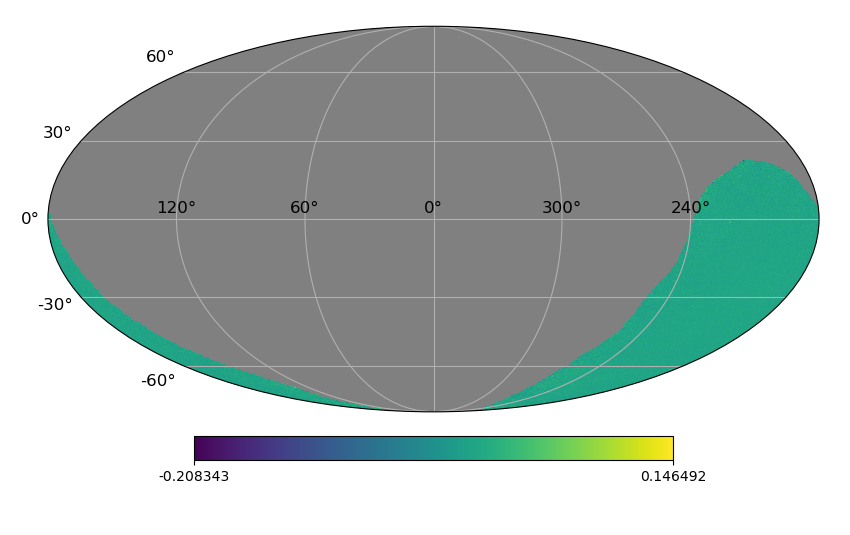

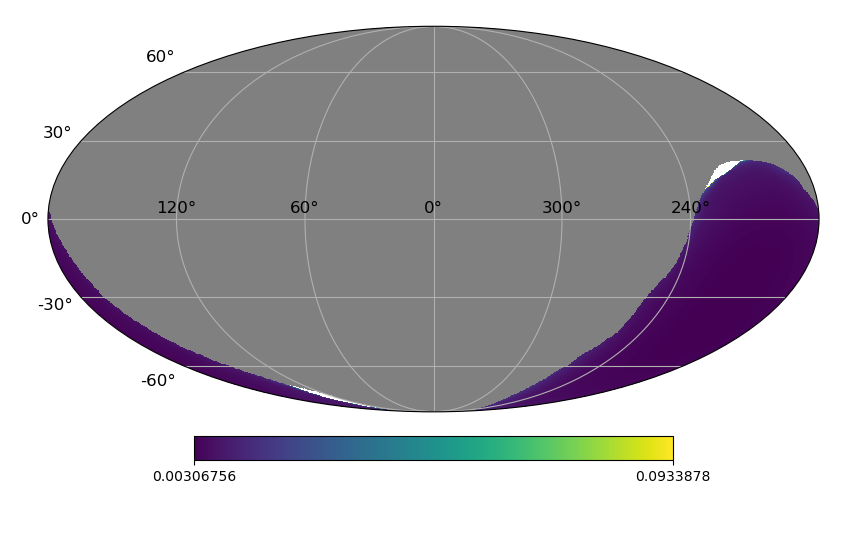

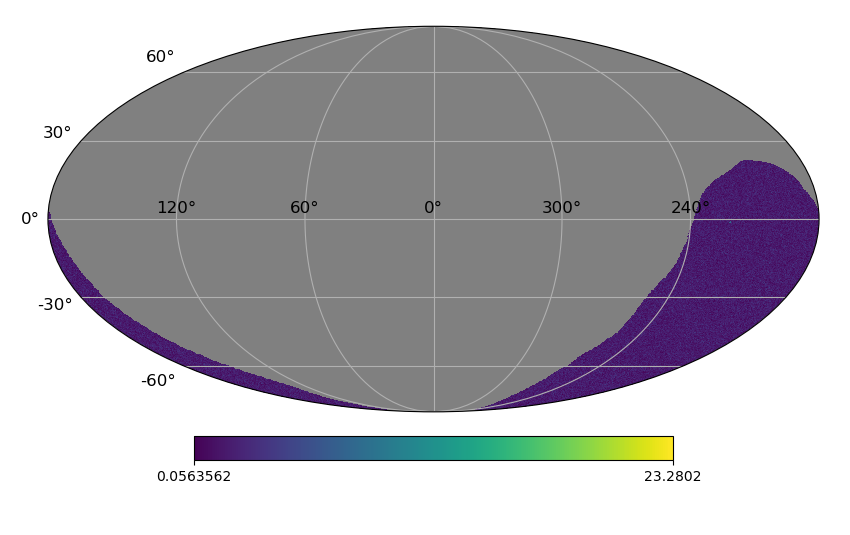

In [25]:
mosaic_skyview.sky_img.plot(coordsys="icrs")
mosaic_skyview.bkg_stddev_img.plot(coordsys="icrs")
mosaic_skyview.snr_img.plot(coordsys="icrs")

When we plot the SNR histogram for the lowest energy bin, we can also see the SNR pixels with SNR>7 which correspond to the healpix pixel containing the GRB and the nearly pixels as well. 

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/var/folders/t4/r1b0srk10n335yds5g1g053c8nkvkq/T/ipykernel_87666/2973102061.py:7: SyntaxWarning: invalid escape sequence '\s'


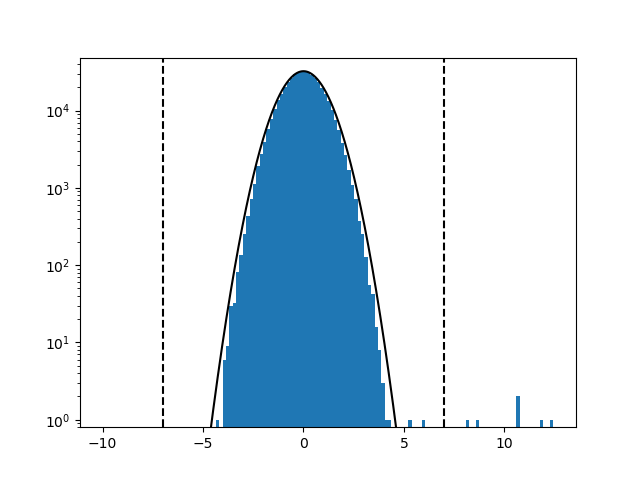

In [26]:
plt.figure()

val, bins, _ =plt.hist(mosaic_skyview.snr_img.slice[dict(ENERGY=0)].project("HPX").contents, bins=100)

g = Gaussian1D(amplitude=val.max(), stddev=1)
x = np.arange(-10, 10, .01)
plt.plot(x, g(x), 'k-', label=r"$\sigma=1$")
plt.yscale("log")
plt.ylim([0.8,1.5*val.max()])


plt.axvline(-7, color='k', ls='--')
plt.axvline(7, color='k', ls='--')

plt.yscale("log")

